In [1]:
from qiskit import *
from math import *
import qiskit.ignis.verification.tomography as tomo

#----------Pour simulation noiseless---------------
%matplotlib inline
from qiskit.tools.visualization import plot_histogram
QASM_simulator = Aer.get_backend('qasm_simulator')

#----------POUR CALCULS ON QC---------------------
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
qcomp = provider.get_backend('ibmq_essex')
from qiskit.tools.monitor import job_monitor

#----------Pour simuler with noise le QC chargé au dessus: ----------
from qiskit.providers.aer import noise
properties = qcomp.properties()
coupling_map = qcomp.configuration().coupling_map
# (Generate an Aer noise model for qcomp)
noise_model = noise.device.basic_device_noise_model(properties)
basis_gates = noise_model.basis_gates

#Pour créer le module de mitigation:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)

In [2]:
#Création du circuit: 
n = 2 #number of qubit
circuit_template = QuantumCircuit(n, n, name="initializer_circ")

circuit_template.h(0)
circuit_template.barrier()


circuit_template.measure(range(n), range(n))

circuit_template.draw()

In [3]:
#Création du module de mitigation
qr = qiskit.QuantumRegister(2)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

job = qiskit.execute(meas_calibs, backend=QASM_simulator,noise_model=noise_model, shots=10000)
cal_results = job.result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
meas_filter = meas_fitter.filter

print(meas_fitter.cal_matrix)

[[9.619e-01 5.160e-02 2.630e-02 1.600e-03]
 [1.940e-02 9.306e-01 4.000e-04 2.660e-02]
 [1.840e-02 1.400e-03 9.580e-01 4.810e-02]
 [3.000e-04 1.640e-02 1.530e-02 9.237e-01]]


In [4]:
TypeOfRun = 2
#1 == simulator w/o noise
#2 == simulator w noise
#3 == QC


alpha = []
dalpha = 0.1
Exp_Val = []

dN = 2500
N = 0

k = 1 #To count how many times we want to do the same experience

#loop for the number of times the experiment is done
while True: 
    i = 0
    N = N + dN
    #k = k+1
    
    
    if TypeOfRun == 1 :
        filestream=open('QVE_p_sim_N='+str(N)+'_'+str(k)+'.txt','w+')
    elif TypeOfRun == 2 :
        filestream=open('QVE_w_noise_N='+str(N)+'_'+str(k)+'.txt','w+')
    elif TypeOfRun == 3 :
        filestream=open('QVE_qc_N='+str(N)+'.txt','w+')

    alpha.clear()
    Exp_Val.clear()
    alpha.append(3)
    
    #main loop, stops when smaller than epsilon 
    while True:

        normalisation = sqrt(2*(1+(1-alpha[i])**2))

        starting_vector = [
           (1-alpha[i])/normalisation,
            1/normalisation,
            1/normalisation,
           (1-alpha[i])/normalisation]

        n = 2 #number of qubit


        circuit = QuantumCircuit(n, n, name="initializer_circ")
        circuit.initialize(starting_vector, [0, 1])

        circuit.h(0)

        circuit.measure(range(n), range(n))
        if TypeOfRun == 1:
            result = execute(circuit, backend=QASM_simulator, shots=N).result()
        elif TypeOfRun == 2:
            result = execute(circuit, backend = QASM_simulator,
                      coupling_map=coupling_map,
                      noise_model=noise_model,
                      basis_gates=basis_gates,
                      shots=N).result()
        elif TypeOfRun == 3:
            job = execute(circuit, backend=qcomp, shots = N)
            job_monitor(job)
            result = job.result()

        #counts = result.get_counts(circuit)
        mitigated_results = meas_filter.apply(result)
        counts = mitigated_results.get_counts(0)

        A = 0
        if counts.get('00'):
            A = A + counts.get('00')
        if counts.get('01'):
            A = A - counts.get('01')
        if counts.get('10'):
            A = A + counts.get('10')
        if counts.get('11'):
            A = A - counts.get('11')
        A = A / N

        circuit = QuantumCircuit(n, n, name="initializer_circ")
        circuit.initialize(starting_vector, [0, 1])

        circuit.h(1)

        circuit.measure(range(n), range(n))
        if TypeOfRun == 1:
            result = execute(circuit, backend=QASM_simulator, shots=N ).result()
        elif TypeOfRun == 2:
            result = execute(circuit, backend = QASM_simulator,
                      coupling_map=coupling_map,
                      noise_model=noise_model,
                      basis_gates=basis_gates,
                      shots=N).result()
        elif TypeOfRun == 3:
            job = execute(circuit, backend=qcomp, shots = N)
            job_monitor(job)
            result = job.result()

        #counts = result.get_counts(circuit)
        mitigated_results = meas_filter.apply(result)
        counts = mitigated_results.get_counts(0)

        B = 0
        if counts.get('00'):
            B = B + counts.get('00')
        if counts.get('01'):
            B = B + counts.get('01')
        if counts.get('10'):
            B = B - counts.get('10')
        if counts.get('11'):
            B = B - counts.get('11')
        B = B / N


        circuit = QuantumCircuit(n, n, name="initializer_circ")
        circuit.initialize(starting_vector, [0, 1])


        circuit.measure(range(n), range(n))
        if TypeOfRun == 1:
            result = execute(circuit, backend=QASM_simulator, shots =N).result()
        elif TypeOfRun == 2:
            result = execute(circuit, backend = QASM_simulator,
                      coupling_map=coupling_map,
                      noise_model=noise_model,
                      basis_gates=basis_gates,
                      shots=N).result()
        elif TypeOfRun == 3:
            job = execute(circuit, backend=qcomp, shots = N)
            job_monitor(job)
            result = job.result()

        #counts = result.get_counts(circuit)
        mitigated_results = meas_filter.apply(result)
        counts = mitigated_results.get_counts(0)

        C = 0
        if counts.get('00'):
            C = C + counts.get('00')
        if counts.get('01'):
            C = C - counts.get('01')
        if counts.get('10'):
            C = C - counts.get('10')
        if counts.get('11'):
            C = C + counts.get('11')
        C = C / N

        Exp_Val.append(0.5*(A+B)+C)

        filestream.write(str(alpha[i])+ ' '+ str(Exp_Val[i])+'\n')

        alpha.append(alpha[i]-dalpha*((2*alpha[i]**2-4)/((alpha[i]**2-2*alpha[i]+2)**2)))
        i = i+1
        if(abs(alpha[i]-alpha[i-1])<0.0001):
            break
    filestream.close()
    print(str(N))
    if(N >= 10000):
    #print(str(k))
    #if(k >= 100):
        break

2500
5000
7500
10000


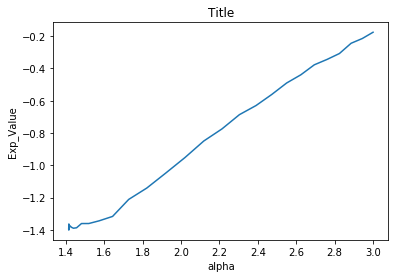

In [5]:
import matplotlib.pyplot as plt 

# plotting the points  
plt.plot(alpha[0:len(alpha)-1], Exp_Val) 
  
# naming the x axis 
plt.xlabel('alpha') 
# naming the y axis 
plt.ylabel('Exp_Value') 
  
# giving a title to my graph 
plt.title('Title') 
  
# function to show the plot 
plt.show() 

In [7]:
Exp_Val

[-0.17630722370438134,
 -0.2151030910329137,
 -0.2445197711672248,
 -0.30812208121020657,
 -0.3442834218344436,
 -0.3778691256356906,
 -0.43972877990085013,
 -0.49042789433570116,
 -0.5616781458867028,
 -0.6302350014698685,
 -0.6865079574383892,
 -0.7746130310314407,
 -0.8496027151025607,
 -0.9521893014792041,
 -1.0481072658060602,
 -1.1409908458162157,
 -1.2111477168876394,
 -1.3164949444845795,
 -1.3437673698108035,
 -1.360444454047275,
 -1.3606186051744134,
 -1.3867738660315578,
 -1.3895796915727128,
 -1.3839940498380536,
 -1.3770796270711065,
 -1.373961465913264,
 -1.3890746332856323,
 -1.3984631924334034,
 -1.3631711274464522,
 -1.3799176745375643,
 -1.4000452781259836,
 -1.391308191678712]